# Colab Setup

Installing Needed Requirements

In [ ]:
! pip install -r requirements.txt

Importing Data from Kaggle

In [2]:
from google.colab import files
files.upload()

! pip install -q kaggle
! mkdir ~/.kaggle # making new directory
! cp kaggle.json ~/.kaggle/ # copying kaggle json file to the created directory
! chmod 600 ~/.kaggle/kaggle.json # changing the permissions
! kaggle datasets download -d sgpjesus/bank-account-fraud-dataset-neurips-2022 # downloading the dataset
! mkdir data # making new directory on colab session to unzip the dataset in it
! unzip -q bank-account-fraud-dataset-neurips-2022.zip -d data # unzipping the downloaded data

Saving kaggle.json to kaggle.json
 96% 525M/546M [00:05<00:00, 82.2MB/s]
100% 546M/546M [00:05<00:00, 109MB/s] 


# Loading the classes

In [1]:
from data_cleaning import *
from modeling import *
from preprocessing import *
from nn_modeling import *

# Splitting the data

Here we'll split data into training and testing same as the provided baseline notebook based on month column

In [2]:
def split_data(df,criteria='random'):
    X = df.drop(['fraud_bool'], axis=1)
    y = df['fraud_bool']
    if criteria=='paper':

        # Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
        X_train = X[X['month']<6]
        X_test = X[X['month']>=6]
        y_train = y[X['month']<6]
        y_test = y[X['month']>=6]


    elif criteria=='random':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    elif criteria=='stratify':

        X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

    X_train.drop('month', axis=1, inplace=True)
    X_test.drop('month', axis=1, inplace=True)
    return X_train, X_test, y_train, y_test

# Reading the data

In [3]:
df=data_cleaning('/content/data/Base.csv').get_data()

In [4]:
# split the data
X_train, X_test, y_train, y_test=split_data(df,criteria= 'paper')

# Getting the groups:

In [5]:
train_groups=(X_train["customer_age"] > 50).map({True: ">50", False: "<=50"})
test_groups=(X_test["customer_age"] > 50).map({True: ">50", False: "<=50"})

# Start the preprocessing

In [6]:
data = preprocessing_class(X_train, y_train)


# Scaling numerical features:

Use "Standard Scaler" for numerical features same as baseline notebook

In [7]:
scalers = {}
for column in X_train.select_dtypes(include=['int','float']):
    m,scaler=data.scale_data('standard',column)
    scalers[column] = scaler

Apply transform on test data

In [8]:
# apply the same scaling on the testset
for column in X_test.select_dtypes(include=['int','float']):
    X_test[column] = scalers[column].transform(X_test[[column]])

# Encoding the categorical features

Using One Hot Encoder

In [9]:
encoders = {}
for column in X_train.select_dtypes(include=['category','object']):
    _, encoder = data.encode_categorical_features(column , encoding_type= 'one-hot')
    encoders[column] = encoder

Transform the test data

In [10]:
# apply the encoding on the testset
for column in X_test.select_dtypes(include=['object','category']).columns:
    ohe=encoders[column]
    encoded_col = pd.DataFrame(ohe.transform(X_test[column].values.reshape(-1, 1)).toarray(),index=X_test.index)
    encoded_col.columns = [column + '_' + str(val) for val in ohe.categories_[0]]
    X_test = pd.concat([X_test, encoded_col], axis=1)
    X_test.drop(columns=column, inplace=True,axis=1)

In [11]:
# arrange the column names according to the concat data
X_test=X_test[data.concat_data().columns]

In [12]:
X_train,y_train=data.get_data()

# Modeling : Training and Evaluation

## Model 1

* Number of hidden layers: 4
* Activation Function: "ReLU"
* Number of units/layer: 128, 64, 64, 32
* Dropout: 0.5

In [14]:
# Keras model using dropout and batch normalization
nn_model_1 = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
experiment=nn_modeling(nn_model_1, X_train,X_test,y_train,y_test,train_groups,test_groups)

In [16]:
%%time
hist = experiment.compile_and_train(lr = 1e-2)

Epoch 1/100
1398/1398 [==============================] - 21s 11ms/step - loss: 1.0608 - fn: 1824.0000 - fp: 164397.0000 - tn: 542942.0000 - tp: 6327.0000 - precision: 0.0371 - recall: 0.7762 - f1: 0.0738 - val_loss: 0.4741 - val_fn: 0.0000e+00 - val_fp: 20415.0000 - val_tn: 59084.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 17s 12ms/step - loss: 0.9967 - fn: 1684.0000 - fp: 148400.0000 - tn: 558939.0000 - tp: 6467.0000 - precision: 0.0418 - recall: 0.7934 - f1: 0.0802 - val_loss: 0.6913 - val_fn: 0.0000e+00 - val_fp: 25467.0000 - val_tn: 54032.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 30s 21ms/step - loss: 0.9763 - fn: 1587.0000 - fp: 152564.0000 - tn: 554775.0000 - tp: 6564.0000 - precision: 0.0412 - recall: 0.8053 - f1: 0.0797 - val_loss: 0.4784 - val_fn: 0.000

6407/6407 [==============================] - 16s 2ms/step
AUC: 0.8849160009746918
TPR:  52.190000000000005% 
FPR:  5.0% 
Threshold:  0.84
Predictive Equality:  99.25%


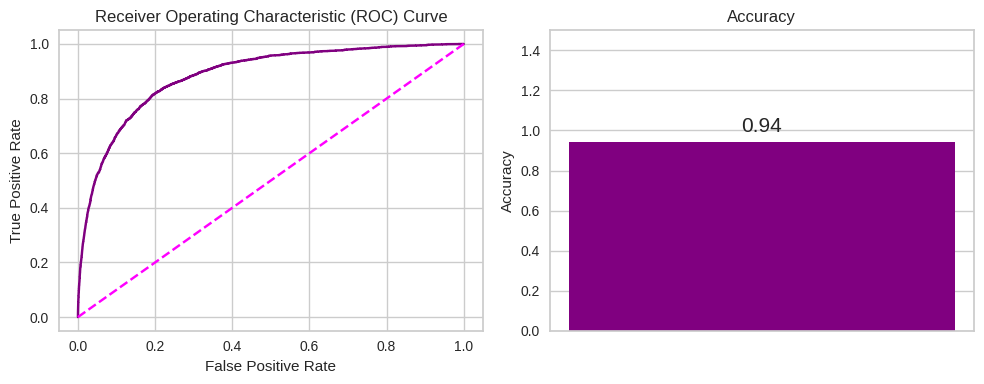

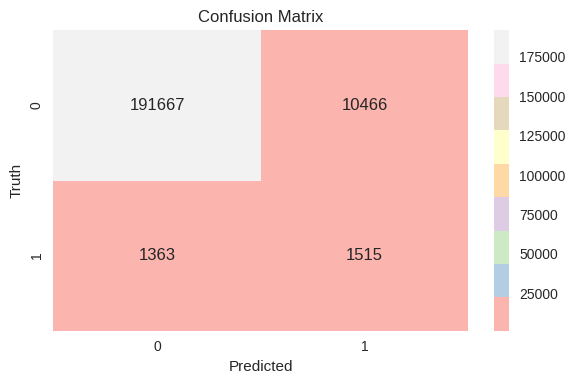

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    202133
           1       0.13      0.53      0.20      2878

    accuracy                           0.94    205011
   macro avg       0.56      0.74      0.59    205011
weighted avg       0.98      0.94      0.96    205011



In [17]:
experiment.score_keras_model()

In [18]:
# Save the best model
saved_model_path = experiment.save_model('nn_model_1')
print("Model saved at:", saved_model_path)

Model saved at: nn_model_1


Saved Model Upload

In [29]:
# Pass the custom objects dictionary to a custom object scope and place
# the `keras.models.load_model()` call within the scope.

def f1(self, y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

custom_objects = {"f1": f1}

with keras.saving.custom_object_scope(custom_objects):
    reconstructed_model = keras.models.load_model("nn_model.keras")

# Or
# reconstructed_model = keras.models.load_model("nn_model.keras",
#                                               custom_objects={"f1": f1},)

# Let's check:
#np.testing.assert_allclose(experiment.model.predict(X_test), reconstructed_model.predict(X_test))

## Model 2
* Number of hidden layers: 5
* Activation Function: "ReLU"
* Number of units/layer: 128, 256, 256, 128, 32
* Dropout: 0.5

In [19]:
# Keras model using dropout and batch normalization
nn_model_2 = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
experiment_2 =nn_modeling(nn_model_2, X_train,X_test,y_train,y_test,train_groups,test_groups)

In [21]:
%%time
hist = experiment_2.compile_and_train(lr = 1e-4)

Epoch 1/100
1398/1398 [==============================] - 25s 13ms/step - loss: 1.7369 - fn: 3558.0000 - fp: 333368.0000 - tn: 373971.0000 - tp: 4593.0000 - precision: 0.0136 - recall: 0.5635 - f1: 0.0265 - val_loss: 0.5164 - val_fn: 0.0000e+00 - val_fp: 8474.0000 - val_tn: 71025.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 15s 11ms/step - loss: 1.4179 - fn: 2655.0000 - fp: 287173.0000 - tn: 420166.0000 - tp: 5496.0000 - precision: 0.0188 - recall: 0.6743 - f1: 0.0366 - val_loss: 0.4811 - val_fn: 0.0000e+00 - val_fp: 16130.0000 - val_tn: 63369.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 15s 11ms/step - loss: 1.2200 - fn: 2155.0000 - fp: 226802.0000 - tn: 480537.0000 - tp: 5996.0000 - precision: 0.0258 - recall: 0.7356 - f1: 0.0499 - val_loss: 0.4546 - val_fn: 0.0000

6407/6407 [==============================] - 13s 2ms/step
AUC: 0.8490810679571447
TPR:  42.46% 
FPR:  5.0% 
Threshold:  0.52
Predictive Equality:  100.0%


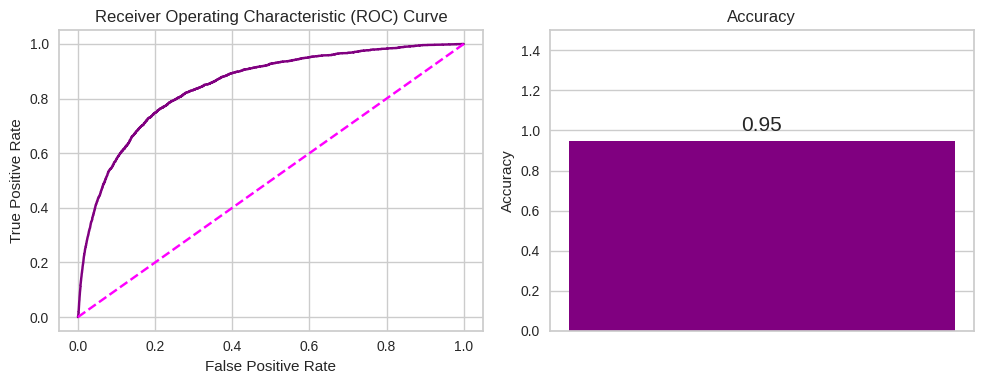

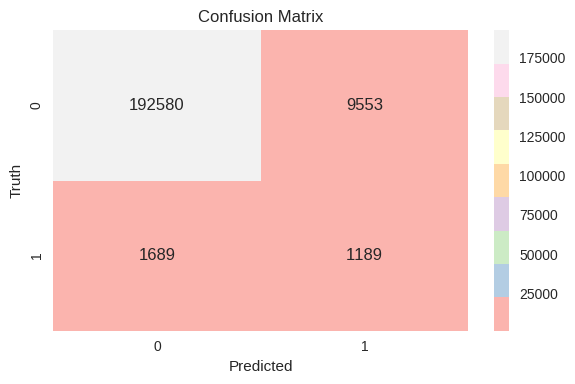

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    202133
           1       0.11      0.41      0.17      2878

    accuracy                           0.95    205011
   macro avg       0.55      0.68      0.57    205011
weighted avg       0.98      0.95      0.96    205011



In [22]:
experiment_2.score_keras_model()

In [29]:
# Save the best model
saved_model_path = experiment_2.save_model('nn_model_2')
print("Model saved at:", saved_model_path)

Model saved at: nn_model_2


## Model 3

* Number of hidden layers: 3
* Activation Function: "ReLU"
* Number of units/layer: 128, 256, 32
* Dropout: 0.2

In [24]:
# Keras model using dropout and batch normalization
nn_model_3 = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')
])

In [25]:
experiment_3 =nn_modeling(nn_model_3, X_train,X_test,y_train,y_test,train_groups,test_groups)

In [26]:
%%time
hist = experiment_3.compile_and_train(lr = 1e-3)

Epoch 1/100
1398/1398 [==============================] - 18s 10ms/step - loss: 1.0033 - fn: 1534.0000 - fp: 179644.0000 - tn: 527695.0000 - tp: 6617.0000 - precision: 0.0355 - recall: 0.8118 - f1: 0.0685 - val_loss: 0.5948 - val_fn: 0.0000e+00 - val_fp: 22700.0000 - val_tn: 56799.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 12s 9ms/step - loss: 0.9205 - fn: 1410.0000 - fp: 164602.0000 - tn: 542737.0000 - tp: 6741.0000 - precision: 0.0393 - recall: 0.8270 - f1: 0.0750 - val_loss: 0.5007 - val_fn: 0.0000e+00 - val_fp: 21518.0000 - val_tn: 57981.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 12s 9ms/step - loss: 0.8961 - fn: 1335.0000 - fp: 160831.0000 - tn: 546508.0000 - tp: 6816.0000 - precision: 0.0407 - recall: 0.8362 - f1: 0.0773 - val_loss: 0.5453 - val_fn: 0.0000e

6407/6407 [==============================] - 15s 2ms/step
AUC: 0.8809012591276923
TPR:  50.17% 
FPR:  5.0% 
Threshold:  0.86
Predictive Equality:  90.12%


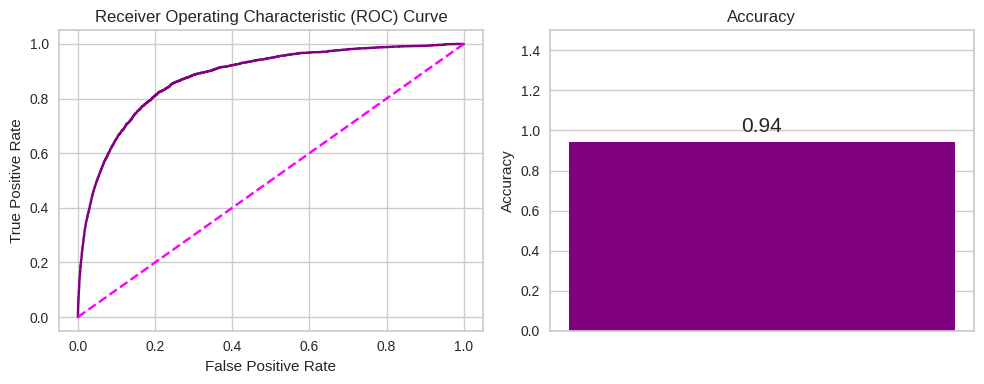

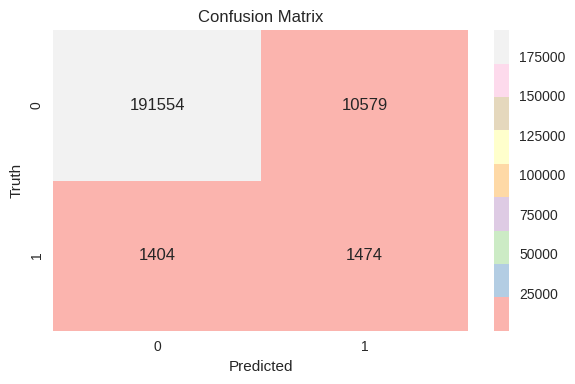

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    202133
           1       0.12      0.51      0.20      2878

    accuracy                           0.94    205011
   macro avg       0.56      0.73      0.58    205011
weighted avg       0.98      0.94      0.96    205011



In [27]:
experiment_3.score_keras_model()

In [28]:
# Save the best model
saved_model_path = experiment_3.save_model('nn_model_3')
print("Model saved at:", saved_model_path)

Model saved at: nn_model_3


## Model 4
* Number of hidden layers: 4
* Activation Function: "tanh"
* Number of units/layer: 64, 128, 128, 64
* Dropout: 0.2 - 0.4

In [30]:
# Keras model using dropout and batch normalization
nn_model_4 = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

In [31]:
experiment_4 =nn_modeling(nn_model_4, X_train,X_test,y_train,y_test,train_groups,test_groups)

In [32]:
%%time
hist = experiment_4.compile_and_train(lr = 1e-3)

Epoch 1/100
1398/1398 [==============================] - 21s 11ms/step - loss: 1.0386 - fn: 1523.0000 - fp: 201918.0000 - tn: 505421.0000 - tp: 6628.0000 - precision: 0.0318 - recall: 0.8132 - f1: 0.0618 - val_loss: 0.7353 - val_fn: 0.0000e+00 - val_fp: 25567.0000 - val_tn: 53932.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 14s 10ms/step - loss: 0.9657 - fn: 1495.0000 - fp: 171312.0000 - tn: 536027.0000 - tp: 6656.0000 - precision: 0.0374 - recall: 0.8166 - f1: 0.0712 - val_loss: 0.6139 - val_fn: 0.0000e+00 - val_fp: 22320.0000 - val_tn: 57179.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 13s 10ms/step - loss: 0.9428 - fn: 1479.0000 - fp: 162690.0000 - tn: 544649.0000 - tp: 6672.0000 - precision: 0.0394 - recall: 0.8185 - f1: 0.0747 - val_loss: 0.5919 - val_fn: 0.000

6407/6407 [==============================] - 13s 2ms/step
AUC: 0.87556457599988
TPR:  48.58% 
FPR:  5.0% 
Threshold:  0.94
Predictive Equality:  79.67%


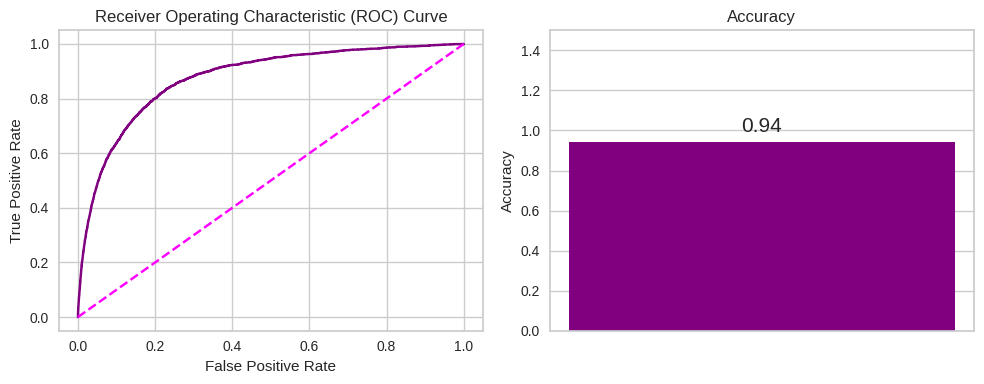

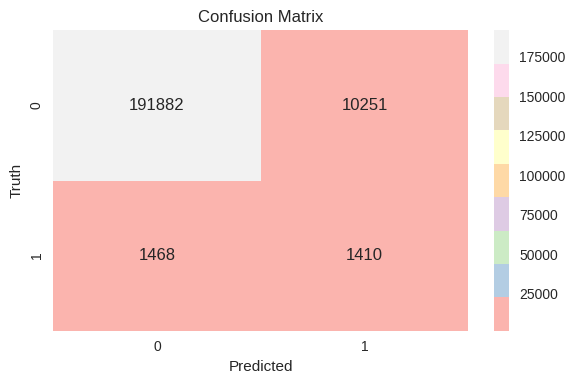

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    202133
           1       0.12      0.49      0.19      2878

    accuracy                           0.94    205011
   macro avg       0.56      0.72      0.58    205011
weighted avg       0.98      0.94      0.96    205011



In [33]:
experiment_4.score_keras_model()

In [34]:
# Save the best model
saved_model_path = experiment_4.save_model('nn_model_4')
print("Model saved at:", saved_model_path)

Model saved at: nn_model_4


## Model 5

* Number of hidden layers: 4
* Activation Function: "LeakyReLU"
* Number of units/layer: 128, 64, 64, 32
* Dropout: 0.5

In [35]:
from keras.layers import LeakyReLU
# Keras model using dropout and batch normalization
nn_model_5 = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(128),
    LeakyReLU(alpha=0.01),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64),
    LeakyReLU(alpha=0.01),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64),
    LeakyReLU(alpha=0.01),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32),
    LeakyReLU(alpha=0.01),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [36]:
experiment_5 =nn_modeling(nn_model_5, X_train,X_test,y_train,y_test,train_groups,test_groups)

In [37]:
%%time
hist = experiment_5.compile_and_train(lr = 1e-2)

Epoch 1/100
1398/1398 [==============================] - 21s 11ms/step - loss: 1.0594 - fn: 1669.0000 - fp: 178045.0000 - tn: 529294.0000 - tp: 6482.0000 - precision: 0.0351 - recall: 0.7952 - f1: 0.0701 - val_loss: 0.7673 - val_fn: 0.0000e+00 - val_fp: 24554.0000 - val_tn: 54945.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 13s 9ms/step - loss: 0.9964 - fn: 1590.0000 - fp: 157460.0000 - tn: 549879.0000 - tp: 6561.0000 - precision: 0.0400 - recall: 0.8049 - f1: 0.0768 - val_loss: 0.7132 - val_fn: 0.0000e+00 - val_fp: 26422.0000 - val_tn: 53077.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 14s 10ms/step - loss: 0.9803 - fn: 1542.0000 - fp: 153369.0000 - tn: 553970.0000 - tp: 6609.0000 - precision: 0.0413 - recall: 0.8108 - f1: 0.0791 - val_loss: 0.4275 - val_fn: 0.0000

6407/6407 [==============================] - 16s 2ms/step
AUC: 0.8795321815698673
TPR:  49.51% 
FPR:  5.0% 
Threshold:  0.94
Predictive Equality:  96.8%


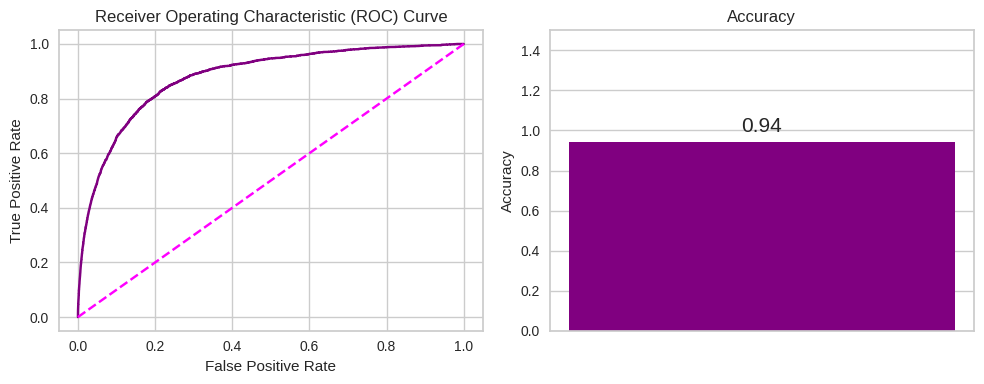

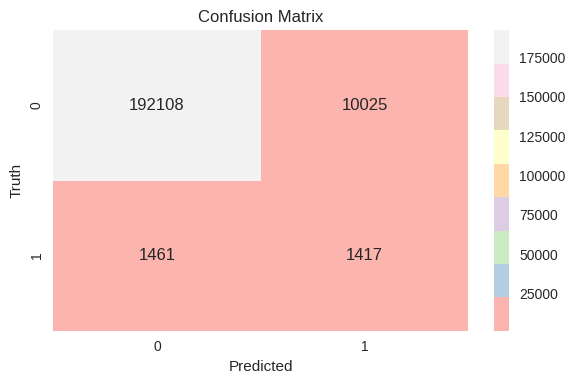

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    202133
           1       0.12      0.49      0.20      2878

    accuracy                           0.94    205011
   macro avg       0.56      0.72      0.58    205011
weighted avg       0.98      0.94      0.96    205011



In [38]:
experiment_5.score_keras_model()

In [39]:
# Save the best model
saved_model_path = experiment_5.save_model('nn_model_5')
print("Model saved at:", saved_model_path)

Model saved at: nn_model_5


## Model 6
* Number of hidden layers: 4
* Activation Function: "ReLU"
* Number of units/layer: 128, 32, 32, 32
* Dropout: 0.1

In [13]:
# Keras model using dropout and batch normalization
nn_model_6 = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
experiment_6=nn_modeling(nn_model_6, X_train,X_test,y_train,y_test,train_groups,test_groups)

In [15]:
%%time
hist = experiment_6.compile_and_train(lr = 1e-2)

Epoch 1/100
1398/1398 [==============================] - 21s 10ms/step - loss: 0.9800 - fn: 1588.0000 - fp: 163573.0000 - tn: 543766.0000 - tp: 6563.0000 - precision: 0.0386 - recall: 0.8052 - f1: 0.0746 - val_loss: 0.5154 - val_fn: 0.0000e+00 - val_fp: 22752.0000 - val_tn: 56747.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 13s 9ms/step - loss: 0.9271 - fn: 1370.0000 - fp: 162864.0000 - tn: 544475.0000 - tp: 6781.0000 - precision: 0.0400 - recall: 0.8319 - f1: 0.0767 - val_loss: 0.4829 - val_fn: 0.0000e+00 - val_fp: 16628.0000 - val_tn: 62871.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 13s 9ms/step - loss: 0.9131 - fn: 1370.0000 - fp: 155881.0000 - tn: 551458.0000 - tp: 6781.0000 - precision: 0.0417 - recall: 0.8319 - f1: 0.0798 - val_loss: 0.5694 - val_fn: 0.0000e

6407/6407 [==============================] - 14s 2ms/step
AUC: 0.885652636590457
TPR:  52.190000000000005% 
FPR:  5.0% 
Threshold:  0.88
Predictive Equality:  91.32000000000001%


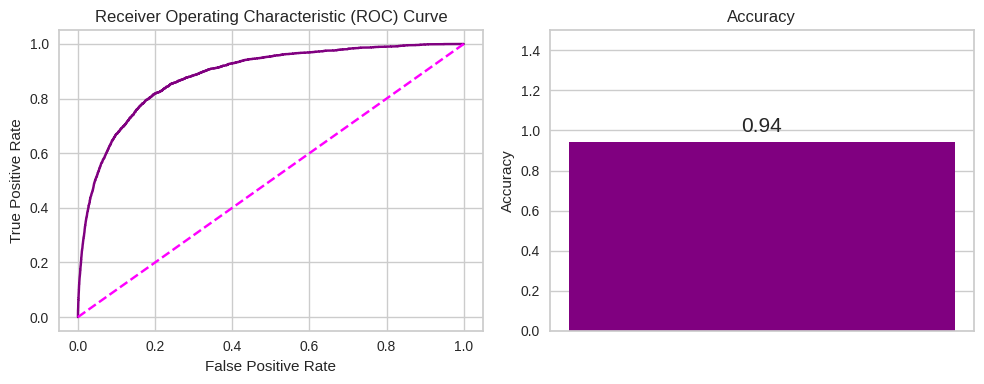

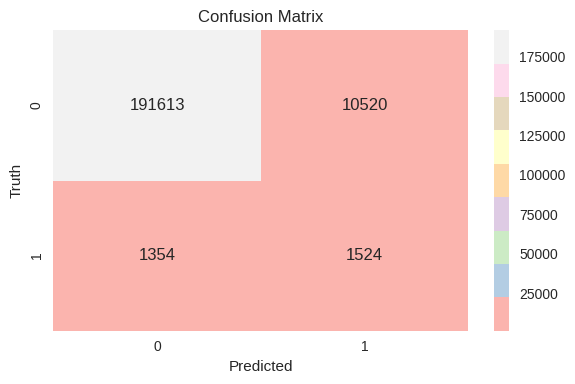

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    202133
           1       0.13      0.53      0.20      2878

    accuracy                           0.94    205011
   macro avg       0.56      0.74      0.59    205011
weighted avg       0.98      0.94      0.96    205011



In [16]:
experiment_6.score_keras_model()

In [19]:
# Save the best model
saved_model_path = experiment_6.save_model('nn_model_6.h5')
print("Model saved at:", saved_model_path)

Model saved at: nn_model_6.h5


Saved Model Upload

In [ ]:
# Pass the custom objects dictionary to a custom object scope and place
# the `keras.models.load_model()` call within the scope.

def f1(self, y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

custom_objects = {"f1": f1}

with keras.saving.custom_object_scope(custom_objects):
    reconstructed_model = keras.models.load_model("nn_model.keras")

# Or
# reconstructed_model = keras.models.load_model("nn_model.keras",
#                                               custom_objects={"f1": f1},)

# Let's check:
#np.testing.assert_allclose(experiment.model.predict(X_test), reconstructed_model.predict(X_test))

## Model 7
* Number of hidden layers: 7
* Activation Function: "ReLU"
* Number of units/layer: 128, 64, 64, 64, 32, 32, 32
* Dropout: 0.1

In [20]:
# Keras model using dropout and batch normalization
nn_model_7 = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')
])

In [21]:
experiment_7=nn_modeling(nn_model_7, X_train,X_test,y_train,y_test,train_groups,test_groups)

In [22]:
%%time
hist = experiment_7.compile_and_train(lr = 1e-2)

Epoch 1/100
1398/1398 [==============================] - 29s 14ms/step - loss: 0.9881 - fn: 1650.0000 - fp: 161916.0000 - tn: 545423.0000 - tp: 6501.0000 - precision: 0.0386 - recall: 0.7976 - f1: 0.0749 - val_loss: 0.8302 - val_fn: 0.0000e+00 - val_fp: 35062.0000 - val_tn: 44437.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 18s 13ms/step - loss: 0.9312 - fn: 1509.0000 - fp: 154604.0000 - tn: 552735.0000 - tp: 6642.0000 - precision: 0.0412 - recall: 0.8149 - f1: 0.0790 - val_loss: 0.5919 - val_fn: 0.0000e+00 - val_fp: 19235.0000 - val_tn: 60264.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 18s 13ms/step - loss: 0.9191 - fn: 1438.0000 - fp: 154258.0000 - tn: 553081.0000 - tp: 6713.0000 - precision: 0.0417 - recall: 0.8236 - f1: 0.0799 - val_loss: 0.4783 - val_fn: 0.000

6407/6407 [==============================] - 16s 2ms/step
AUC: 0.8811977306845288
TPR:  50.83% 
FPR:  5.0% 
Threshold:  0.89
Predictive Equality:  93.96%


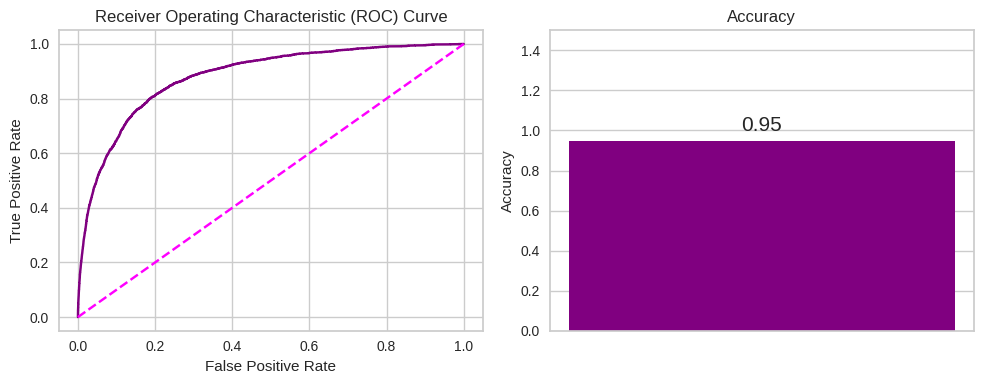

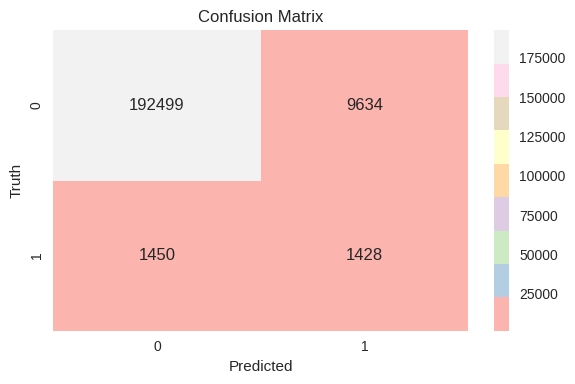

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    202133
           1       0.13      0.50      0.20      2878

    accuracy                           0.95    205011
   macro avg       0.56      0.72      0.59    205011
weighted avg       0.98      0.95      0.96    205011



In [23]:
experiment_7.score_keras_model()

In [24]:
# Save the best model
saved_model_path = experiment_7.save_model('nn_model_7.h5')
print("Model saved at:", saved_model_path)

Model saved at: nn_model_7.h5


## Model 8
* Number of hidden layers: 10
* Activation Function: "ReLU"
* Number of units/layer: 64, 128, 128, 512, 512, 256, 256, 128, 128, 32
* Dropout: 0.2 - 0.6

In [30]:
# Keras model using dropout and batch normalization
nn_model_8 = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.6),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.6),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

In [31]:
experiment_8=nn_modeling(nn_model_8, X_train,X_test,y_train,y_test,train_groups,test_groups)

In [32]:
%%time
hist = experiment_8.compile_and_train(lr = 1e-2)

Epoch 1/100
1398/1398 [==============================] - 36s 19ms/step - loss: 1.1051 - fn: 1932.0000 - fp: 183230.0000 - tn: 524109.0000 - tp: 6219.0000 - precision: 0.0328 - recall: 0.7630 - f1: 0.0693 - val_loss: 0.7256 - val_fn: 0.0000e+00 - val_fp: 23812.0000 - val_tn: 55687.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 22s 16ms/step - loss: 0.9916 - fn: 1770.0000 - fp: 144645.0000 - tn: 562694.0000 - tp: 6381.0000 - precision: 0.0423 - recall: 0.7828 - f1: 0.0812 - val_loss: 0.4320 - val_fn: 0.0000e+00 - val_fp: 18358.0000 - val_tn: 61141.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 24s 17ms/step - loss: 0.9829 - fn: 1644.0000 - fp: 148404.0000 - tn: 558935.0000 - tp: 6507.0000 - precision: 0.0420 - recall: 0.7983 - f1: 0.0805 - val_loss: 0.5736 - val_fn: 0.000

6407/6407 [==============================] - 17s 3ms/step
AUC: 0.8832607021652643
TPR:  51.35999999999999% 
FPR:  5.0% 
Threshold:  0.98
Predictive Equality:  94.06%


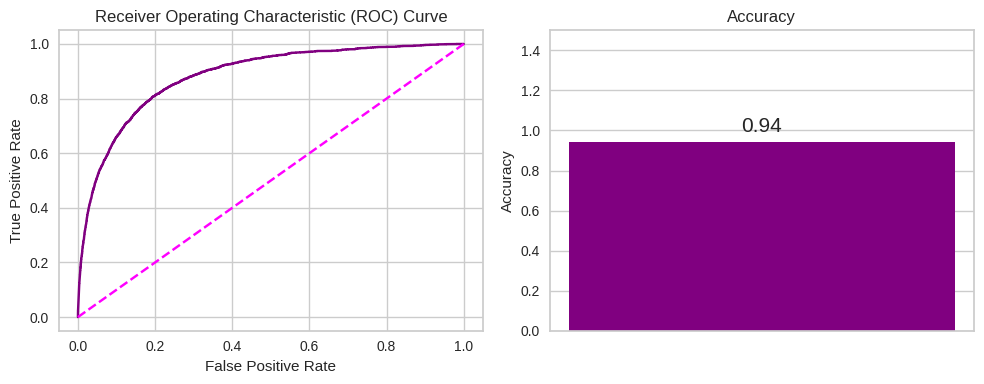

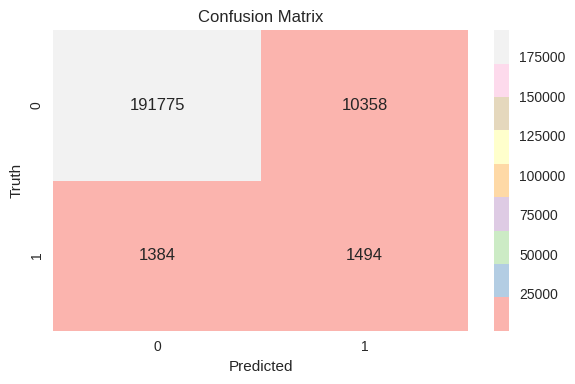

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    202133
           1       0.13      0.52      0.20      2878

    accuracy                           0.94    205011
   macro avg       0.56      0.73      0.59    205011
weighted avg       0.98      0.94      0.96    205011



In [33]:
experiment_8.score_keras_model()

In [34]:
# Save the best model
saved_model_path = experiment_8.save_model('nn_model_8.h5')
print("Model saved at:", saved_model_path)

Model saved at: nn_model_8.h5
